## Multi Fiedelity GPR

Consider the following functions which are indexed by increasing levels of fidelity:

$$f_3(x) = \left(\frac{-1.275 x_1^2}{\pi^2} + \frac{5x_1}{\pi} + x_2 - 6 \right)^2 + \left(10 - \frac{5}{4 \pi}\right) \cos(x_1) + 10,$$
$$f_2(x) = 10 \sqrt{f_3(x - 2)} + 2(x_1 - 0.5) - 3(3x_2 - 1) - 1$$
$$f_1(x) = f_2(1.2(x + 2)) - 3x_2 + 1.$$

Given a set of noiseless multi-fidelity observations of $f_1$, $f_2$ and $f_3$,  train a multi-fidelity GP that can approximate the highest fidelity function $f_3$. Considering $n_1 = 80, n_2 = 40, n_3 = 20$ observations for each of the functions, obtained by randomly sampling in $[-5, 10] \times [0, 15]$, find the relative $\mathbb{L}_2$ error of the high-fidelty function on a test-grid. Report your performance over 100 different trials.


In [26]:
!pip install --upgrade PyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import jax.numpy as np
import numpy as onp
from jax import vmap, jit, vjp, random
from jax.scipy.linalg import cholesky, solve_triangular

from jax.config import config
config.update("jax_enable_x64", True)

from pyDOE import lhs
from functools import partial
from tqdm import trange
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc

onp.random.seed(1234)

# 1. Define the functions:

  $f_3$ is the highest fidelity function and $f_1$ is the lowest fidelity function.

In [28]:
# High fidelity function:
def f3(x1, x2):
    return (-1.275*x1**2/np.pi**2 + 5*x1/np.pi + x2 - 6)**2\
    + (10 - 5/4*np.pi)*np.cos(x1) + 10

# Medium fidelity function:
def f2(x1, x2):
    return 10*np.sqrt(f3(x1-2, x2-2)) + 2*(x1-0.5)\
    - 3*(3*x2-1) - 1

# Low fidelity function:
def f1(x1, x2):
    return f2(1.2*(x1+2), 1.2*(x2-2)) - 3*x2 + 1


# 2. Sampling the inputs:

  $n_1 = 80, n_2 = 40, n_3 = 20$

In [29]:
# random keys for sampling:
key1 = random.PRNGKey(1)
key2 = random.PRNGKey(2)
key3 = random.PRNGKey(3)

nL = 80
nM = 40
nH = 20
# samples for f1
sample_11 = random.uniform(key1, shape=(nL, ), minval=-5, maxval=10)
sample_12 = random.uniform(key1, shape=(nL, ), minval=0, maxval=15)
sample_1 = np.stack([sample_11, sample_12], axis=1) # Data for f1 

# samples for f2
sample_21 = random.uniform(key1, shape=(nM, ), minval=-5, maxval=10)
sample_22 = random.uniform(key1, shape=(nM, ), minval=0, maxval=15)
sample_2 = np.stack([sample_21, sample_22], axis=1) # Data for f3

# samples for f3
sample_31 = random.uniform(key1, shape=(nH, ), minval=-5, maxval=10)
sample_32 = random.uniform(key1, shape=(nH, ), minval=0, maxval=15)
sample_3 = np.stack([sample_31, sample_32], axis=1) # Data for f3

# 3. Evaluate the functions at the sampled points:

In [30]:
evaluate_f1 = f1(sample_1[:, 0], sample_1[:, 1]).reshape(1, 80)
evaluate_f2 = f2(sample_2[:, 0], sample_2[:, 1]).reshape(1, 40)
evaluate_f3 = f3(sample_3[:, 0], sample_3[:, 1]).reshape(1, 20)
f = np.hstack((evaluate_f1, evaluate_f2, evaluate_f3)).T

# 4. Plotting the functions:

In [31]:
# create a meshgrid of x and y values
x = np.linspace(-5, 10, 80)
y = np.linspace(0, 15, 80)
X, Y = np.meshgrid(x, y)

# compute the values of the function on the meshgrid
f_1 = f1(X, Y)
f_2 = f2(X, Y)
f_3 = f3(X, Y)

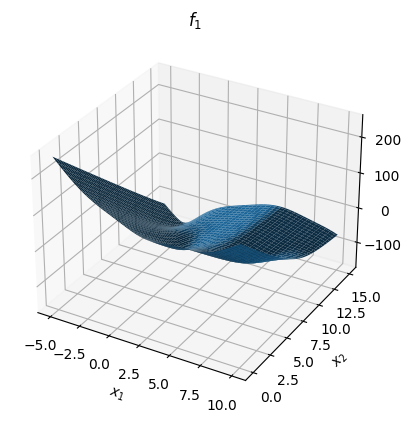

In [32]:
# create a 3D plot of the function-1 using plot_surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, f_1)

# set the axis labels and title
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$f_1$')
plt.show()

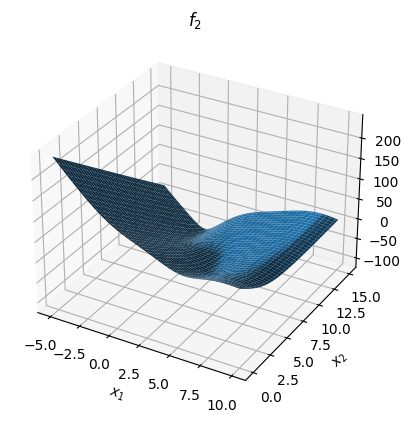

In [33]:
# create a 3D plot of the function-2 using plot_surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, f_2)

# set the axis labels and title
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$f_2$')
plt.show()

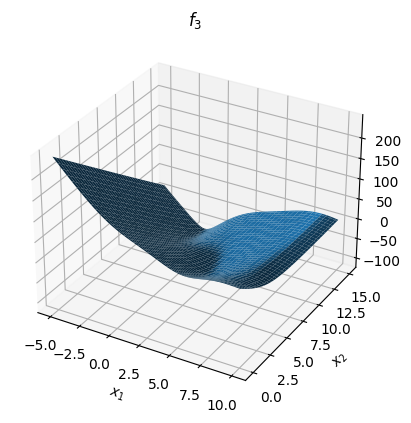

In [34]:
# create a 3D plot of the function-3 using plot_surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, f_2)

# set the axis labels and title
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$f_3$')
plt.show()

# 5. Formulating the model:

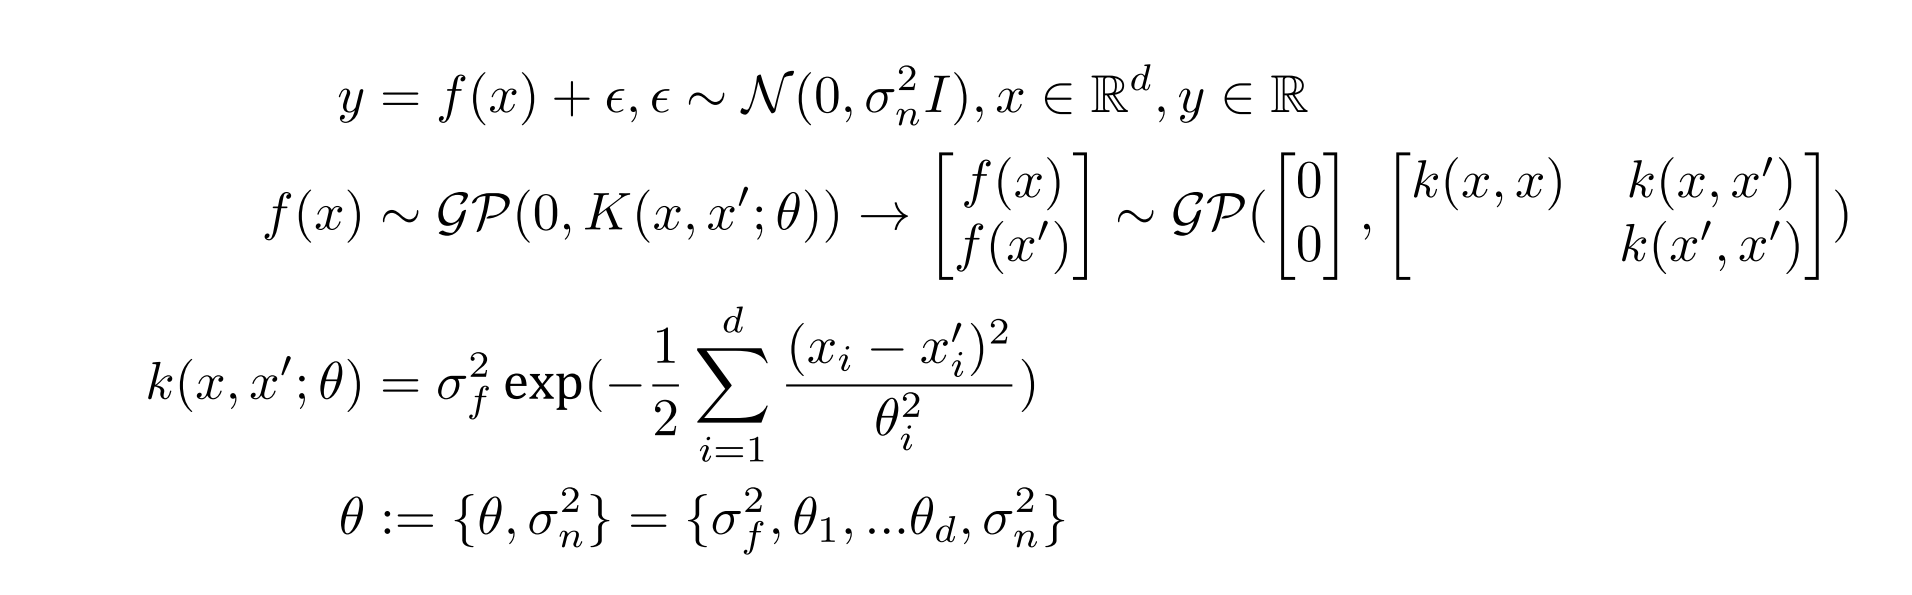

In [35]:
# A vectorized RBF kernel function
def RBF(x1, x2, params):
    output_scale = params[0]
    lengthscales = params[1:]
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [36]:
params = np.array([2, 3, 4])
rbf = RBF(sample_1[:nL], sample_1[:nH], params)
print(rbf.shape)

(80, 20)


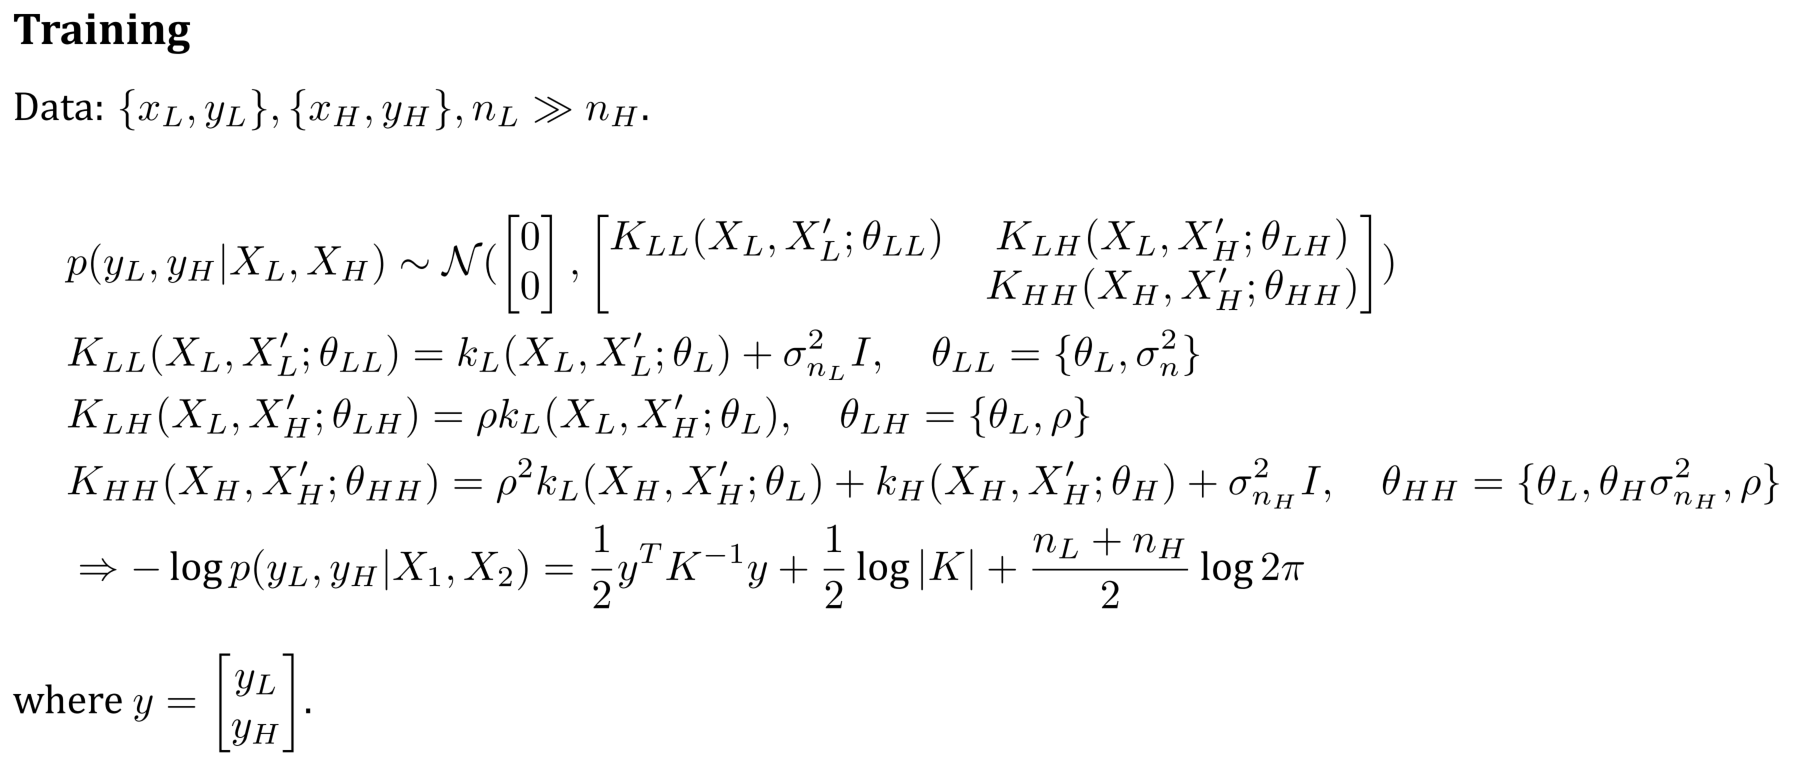

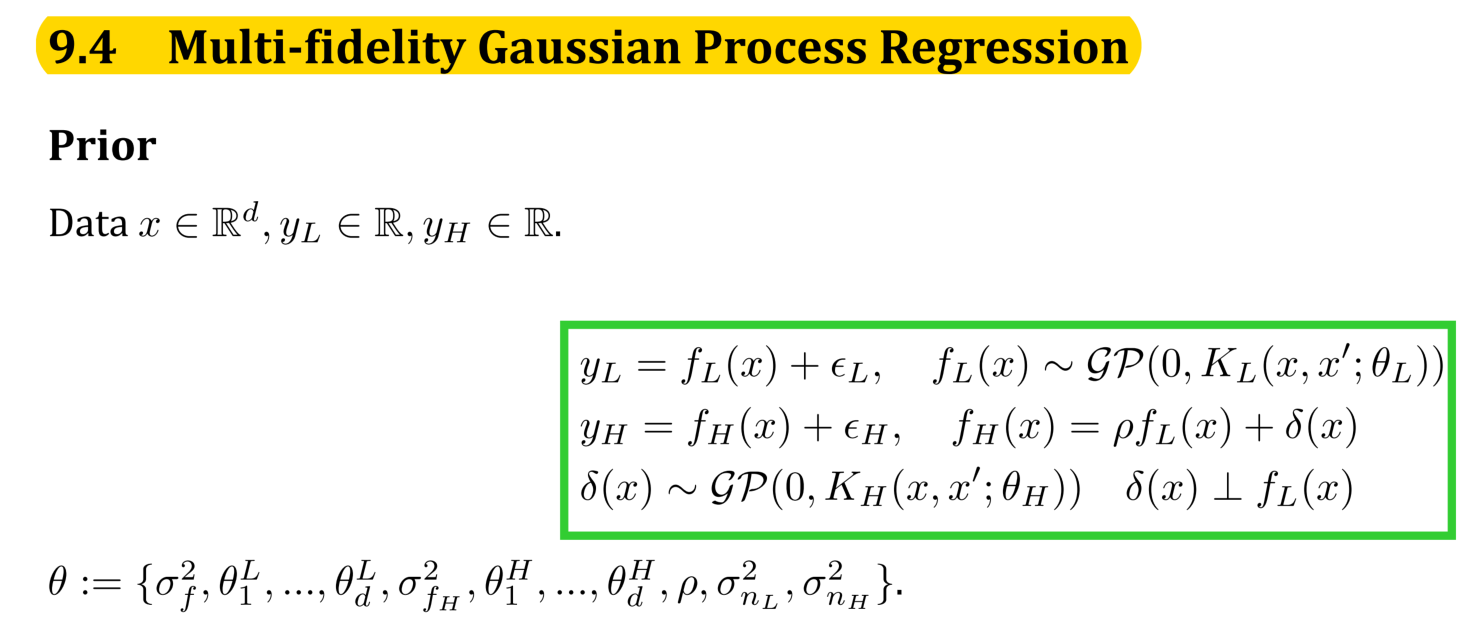

In [37]:
# A minimal Gaussian process class
class GPRegression:
    # Initialize the class
    def __init__(self, kernel_fn = RBF): 
        self.kernel = kernel_fn
    
    # Initialize the hyperparameters: hyp = [sigma_L, theta_L, sigma_M, theta_M, sigma_H,\
    #                                        theta_H, rho, sigma_nL, sigma_nM, sigma_nH]
    def random_init_GP(self, rng_key, dim):
        logsigma_L = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength_L  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)

        logsigma_M = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength_M  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)
        
        logsigma_H = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength_H  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)
        
        log_rho = np.log(50.0*random.uniform(rng_key, (1,)))
        
        logsigma_nL = np.array([-4.0]) + random.normal(rng_key, (1,))
        logsigma_nM = np.array([-4.0]) + random.normal(rng_key, (1,))
        logsigma_nH = np.array([-4.0]) + random.normal(rng_key, (1,))

        hyp = np.concatenate([logsigma_L, loglength_L, logsigma_M, loglength_M, logsigma_H,\
                              loglength_H, log_rho, logsigma_nL, logsigma_nM, logsigma_nH])
        return hyp

    def compute_cholesky(self, params, batch):
        X, _ = batch
        N, D = X.shape
        nL = 20
        nM = 40
        nH = 80
        # Fetch params:
        theta_L = np.exp(params[:3])
        sigma_nL = np.exp(params[10])

        theta_M = np.exp(params[3:6])
        sigma_nM = np.exp(params[11])

        theta_H = np.exp(params[6:9])
        sigma_nH = np.exp(params[12])

        rho = np.exp(params[9])

        # Compute kernel matrix:
        K_LL = self.kernel(X[:nL], X[:nL], theta_L) + np.eye(nL)*(sigma_nL + 1e-8)
        K_LM = rho*self.kernel(X[:nL], X[:nM], theta_L)
        K_MM = rho**2*self.kernel(X[:nM], X[:nM], theta_L)\
               + self.kernel(X[:nM], X[:nM], theta_M) + np.eye(nM)*(sigma_nM + 1e-8)
        K_MH = rho*self.kernel(X[:nM], X, theta_M)
        K_LH = rho*self.kernel(X[:nL], X, theta_L)
        K_HH = rho**2*self.kernel(X, X, theta_L)\
               + rho**2*self.kernel(X, X, theta_M)\
               + self.kernel(X, X, theta_H)

        # stack above matrices to form the new matrix
        top_row = np.hstack((K_LL, K_LM, K_LH))
        middle_row = np.hstack((K_LM.T, K_MM, K_MH))
        bottom_row = np.hstack((K_LH.T, K_MH.T, K_HH))
        
        # The required kernel matrix:
        K = np.vstack((top_row, middle_row, bottom_row))

        L = cholesky(K, lower=True)
        return L
    
    def likelihood(self, params, batch):
        _, y = batch
        N = y.shape[0]
        # Compute Cholesky
        L = self.compute_cholesky(params, batch)
        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T, solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y), alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        X, _ = batch
        dim = X.shape[1]
        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            # initialize the parameters         
            init = self.random_init_GP(rng_key[i], dim)
            # calling the optimizer
            p, val = minimize_lbfgs(objective, init)
            # appending the updated parameters to params list 
            params.append(p) 
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best, :]
        return best_params
    
    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        X, y = batch
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean, std
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))
        return mu, std

    @partial(jit, static_argnums=(0,))
    def draw_posterior_sample(self, rng_key, params, batch, X_star):
        X, y = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        sample = random.multivariate_normal(rng_key, mu, cov)
        return sample

model = GPRegression(kernel_fn = RBF)

# 6. Training the model (Incomplete):
### My loss function is showing Nan values

In [38]:
# A wrapper to call SciPy's L-BFGS-B optimizer
def minimize_lbfgs(objective, x0, bnds = None):
    result = minimize(objective, x0, jac=True,
                      method='L-BFGS-B', bounds = bnds,
                      callback=None)
    return result.x, result.fun

There is no parameter value at the end of the training which is not NaN,
hence the error.

In [47]:
# Train model
mu_f, sigma_f = f.mean(0), f.std(0)
X_norm = (sample_1 - np.min(sample_1, axis=0))/\
         (np.max(sample_1, axis=0) - np.min(sample_1, axis=0))
y_norm = (f - mu_f)/sigma_f 

print(X_norm.shape)
print(y_norm.shape)
train_key = random.PRNGKey(0)
opt_params = model.train((X_norm, y_norm), train_key, num_restarts = 10)

(80, 2)
(140, 1)


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


IndexError: ignored